In [1]:
appid='app-20250517053242-0003'
basedir='/opt/spark/work-dir/profile/'
server="127.0.0.1"

In [2]:
import findspark
findspark.init()

In [3]:
import socket
localhost=socket.gethostname()
local_ip=socket.gethostbyname(localhost)

In [4]:
import os
import time
import sys
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

def get_py4jzip():
    spark_home=os.environ['SPARK_HOME']
    py4jzip = !ls {spark_home}/python/lib/py4j*.zip
    return py4jzip[0]

conf = (SparkConf()
    .set('spark.app.name', f'perf_analysis_{appid}')
    .set('spark.master','spark://'+localhost+":7077")
    .set('spark.serializer','org.apache.spark.serializer.KryoSerializer')
    .set('spark.driver.memory','5g')
    .set('spark.executorEnv.PYTHONPATH',f"{os.environ['SPARK_HOME']}/python:{get_py4jzip()}:{':'.join(sys.path)}")
    .set('spark.sql.execution.arrow.pyspark.fallback.enabled','True')
    .set('spark.sql.execution.arrow.pyspark.enabled','True')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch','100000')
    .set("spark.sql.legacy.timeParserPolicy","LEGACY")
       )

sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
spark = SQLContext(sc)
time.sleep(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/17 06:16:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
%run /opt/spark/work-dir/ipython/sparklog.ipynb

In [6]:
app=Application_Run(appid, basedir=basedir)
appals=app.analysis['app']['als']

total time:  1201.19


,query,elapsed
0,q1,27.59
1,q10,29.15
2,q11,13.37
3,q12,17.95
4,q13,25.38
5,q14,12.45
6,q15,26.74
7,q16,9.17
8,q17,108.2
9,q18,120.1


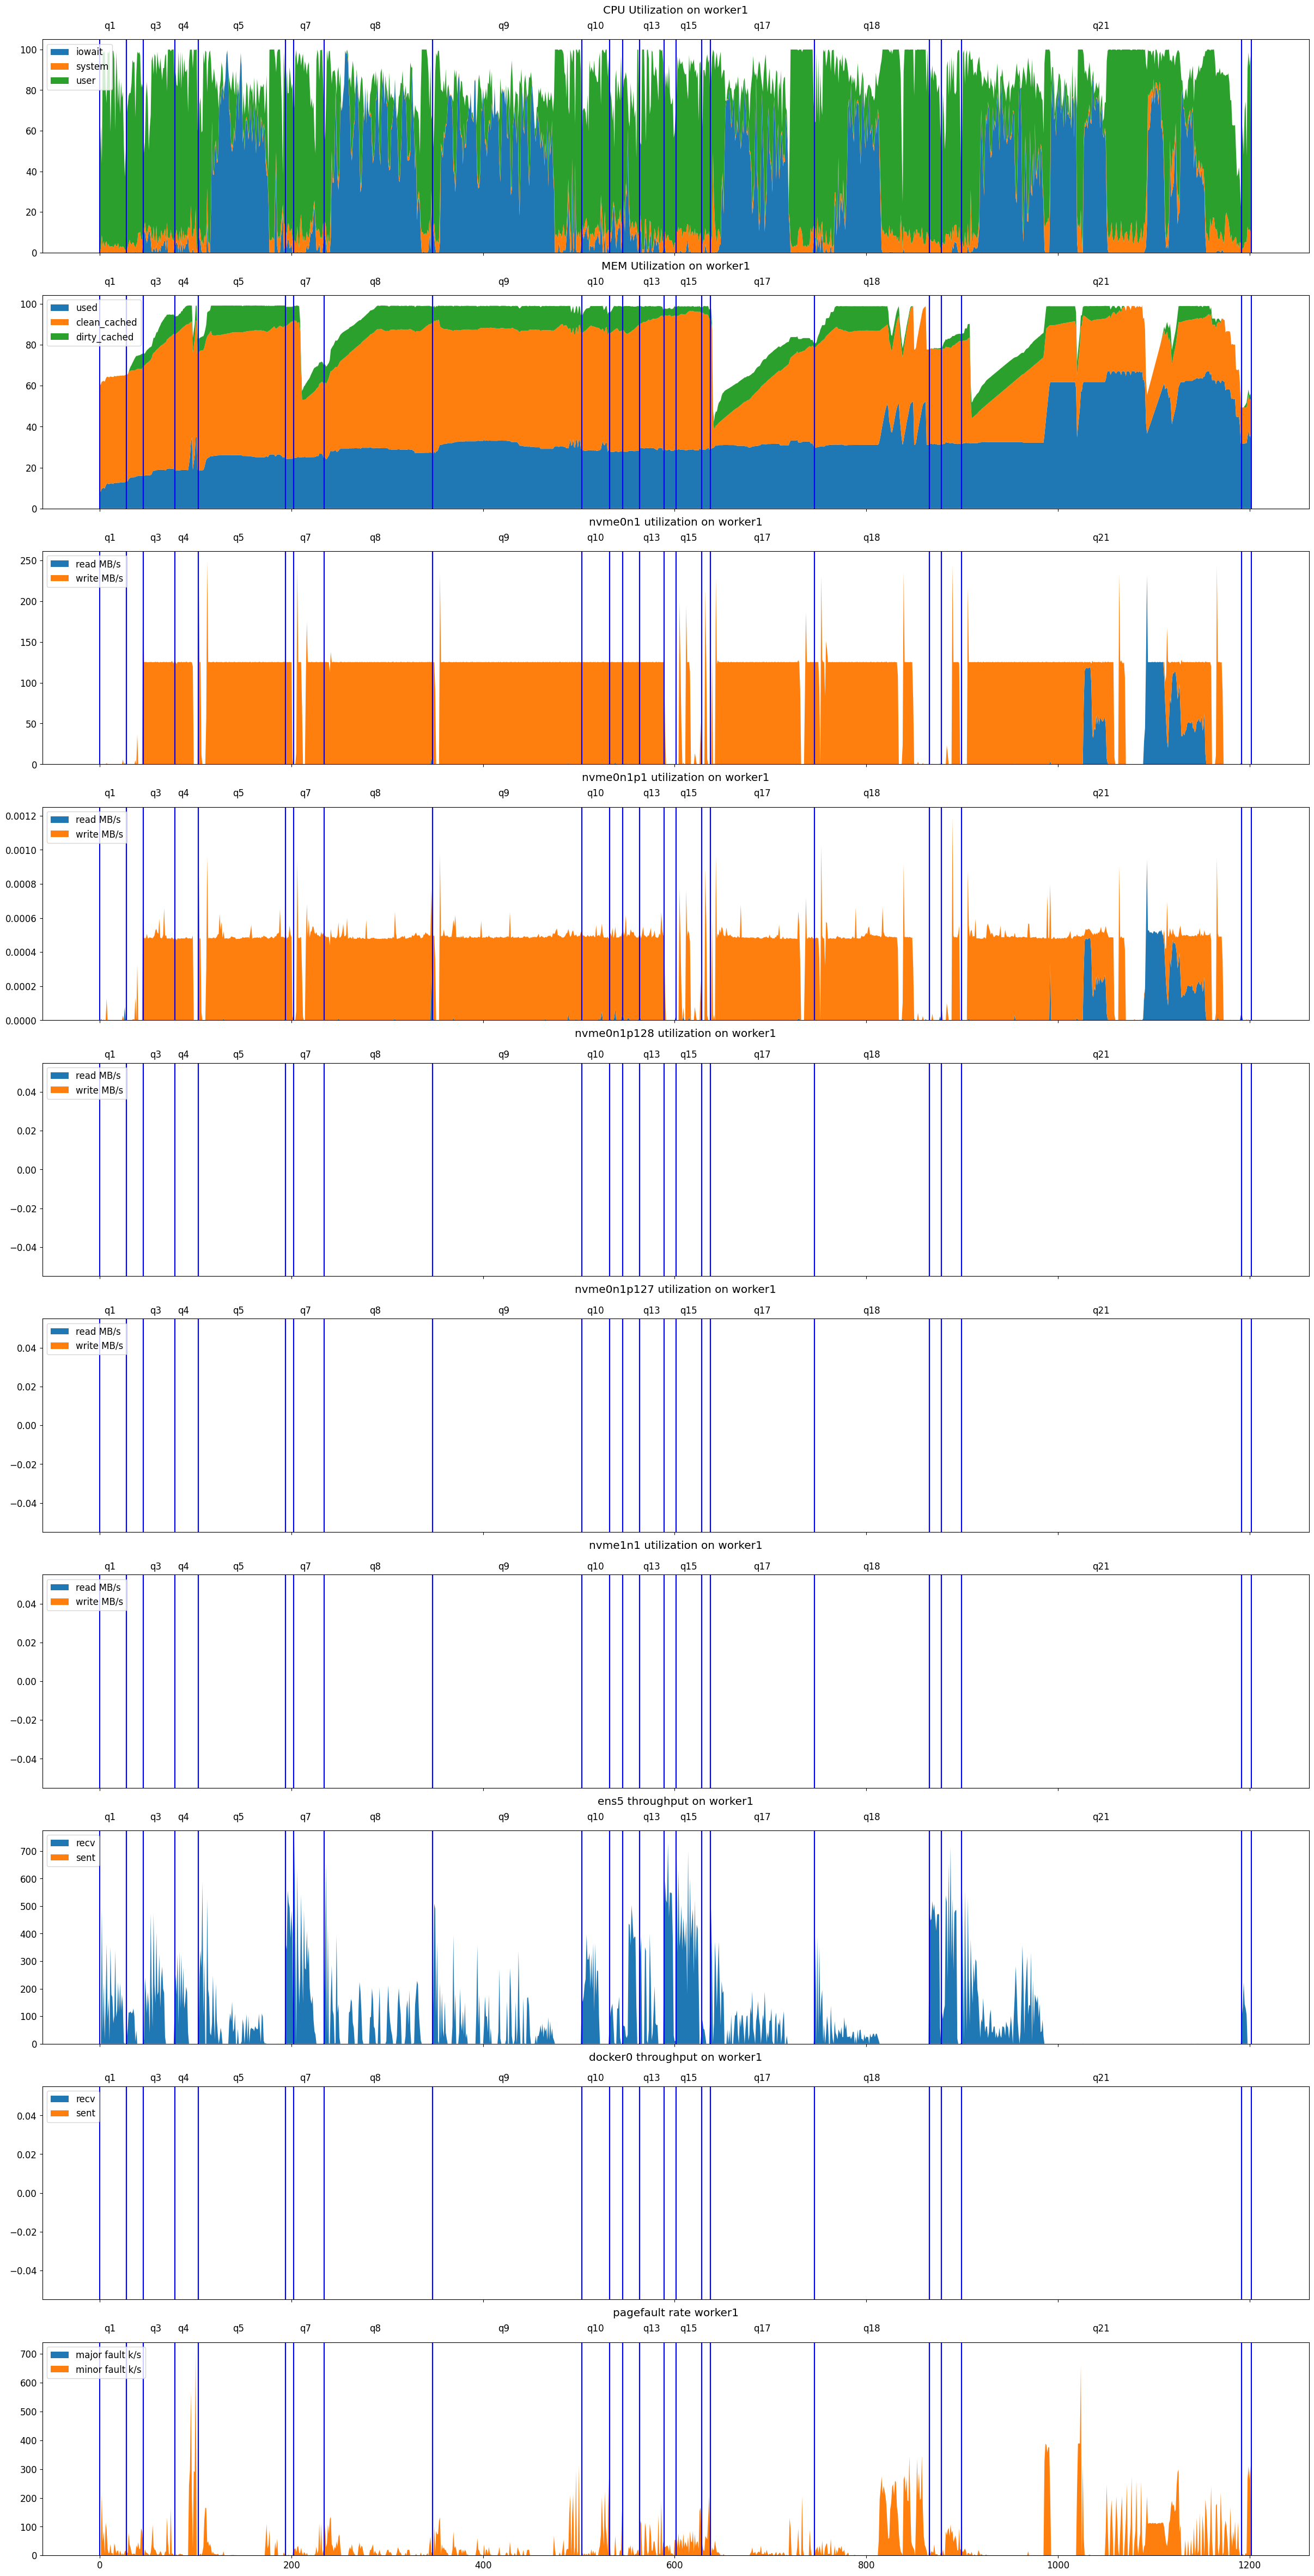

In [7]:
app.drawsar()

In [20]:
subprocess.run('df', capture_output=True, text=True)

CompletedProcess(args='df', returncode=0, stdout='Filesystem     1K-blocks     Used Available Use% Mounted on\noverlay        157208556 18409912 138798644  12% /\ntmpfs              65536        0     65536   0% /dev\nshm                65536        0     65536   0% /dev/shm\n/dev/nvme0n1p1 157208556 18409912 138798644  12% /etc/hosts\ntmpfs           16237664        0  16237664   0% /proc/acpi\ntmpfs           16237664        0  16237664   0% /sys/firmware\n', stderr='')

In [24]:
executors_data['workers']

[{'id': 'worker-20250517045829-10.167.102.54-40401',
  'host': '10.167.102.54',
  'port': 40401,
  'webuiaddress': 'http://10.167.102.54:8081',
  'cores': 8,
  'coresused': 8,
  'coresfree': 0,
  'memory': 30690,
  'memoryused': 1024,
  'memoryfree': 29666,
  'resources': {},
  'resourcesused': {},
  'resourcesfree': {},
  'state': 'ALIVE',
  'lastheartbeat': 1747465334724}]

In [ ]:
:8080/json/

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        157208556 18402848 138805708  12% /
tmpfs              65536        0     65536   0% /dev
shm                65536        0     65536   0% /dev/shm
/dev/nvme0n1p1 157208556 18402832 138805724  12% /etc/hosts
tmpfs           16237664        0  16237664   0% /proc/acpi
tmpfs           16237664        0  16237664   0% /sys/firmware



In [ ]:
stats=appals.get_basic_state()

In [ ]:
summary=app.get_summary()
display(summary.style)

In [ ]:
traceview=app.generate_trace_view()

In [ ]:
appals.get_app_name()

In [ ]:
cfg=appals.get_spark_config()
display(cfg)
cfg=cfg.fillna('')

In [ ]:
appals.get_app_info()

In [ ]:
breakdown=appals.show_critical_path_time_breakdown(plot=False).T
display(breakdown)

In [ ]:
gluten_run_metrics=[]
for idx in breakdown.index:
    gluten_run_metric={}
    gluten_run_metric['appid']=appid
    gluten_run_metric['total_time']=breakdown[0][idx]
    pct=float(idx.split("%")[0])/100
    gluten_run_metric['metric_value']=pct
    gluten_run_metric['metric_name']=idx.split("%")[1]
    gluten_run_metrics.append(gluten_run_metric)

In [ ]:
spark_run_metrics={}
spark_run_metrics["appid"]=stats["appid"]
spark_run_metrics["executor_instances"]=stats["executor.instances"]
spark_run_metrics["executor_cores"]=stats["executor.cores"]
spark_run_metrics["shuffle_partitions"]=stats["shuffle.partitions"]
spark_run_metrics["batch_size"]=stats["batch size"]
spark_run_metrics["real_executors"]=stats["real executors"]
spark_run_metrics["failed_tasks"]=stats["Failed Tasks"]
spark_run_metrics["speculative_tasks"]=stats["Speculative Tasks"]
spark_run_metrics["speculative_kill_tasks"]=stats["Speculative Killed Tasks"]
spark_run_metrics["speculative_stage"]=stats["Speculative Stage"]
spark_run_metrics["runtime"]=stats["runtime"]
spark_run_metrics["disk_spilled"]=stats["disk spilled"]
spark_run_metrics["mem_spilled"]=stats["memspilled"]
spark_run_metrics["local_read"]=stats["local_read"]
spark_run_metrics["remote_read"]=stats["remote_read"]
spark_run_metrics["shuffle_write"]=stats["shuffle_write"]
spark_run_metrics["task_run_time"]=stats["task run time"]
spark_run_metrics["ser_time"]=stats["ser_time"]
spark_run_metrics["f_wait_time"]=stats["f_wait_time"]
spark_run_metrics["gc_time"]=stats["gc_time"]
spark_run_metrics["input_read"]=stats["input read"]
spark_run_metrics["acc_task_time"]=stats["acc_task_time"]
spark_run_metrics["avg_usage_user"]=summary[appid]['avg usage_user']
spark_run_metrics["avg_usage_system"]=summary[appid]['avg usage_system']
spark_run_metrics["avg_usage_iowait"]=summary[appid]['avg usage_iowait']
spark_run_metrics["avg_disk_util"]=summary[appid]['avg disk util']
spark_run_metrics["total_read"]=summary[appid]['total read (G)']
spark_run_metrics["total_write"]=summary[appid]['total write (G)']
spark_run_metrics["cached_mean"]=summary[appid]['cached mean']
spark_run_metrics["used_mean"]=summary[appid]['used mean']
spark_run_metrics["spark_config"]=json.dumps(cfg.to_dict()[cfg.columns[0]])

In [ ]:
query_detail=appals.get_query_time(plot=False)
query_detail=query_detail.reset_index()
query_detail=query_detail.drop('queryid', axis=1)
query_detail=query_detail.drop('stages', axis=1)
query_detail=query_detail.drop('storage read', axis=1)
query_detail=query_detail.drop('ram read', axis=1)
query_detail=query_detail.drop('ssd read', axis=1)
query_detail.rename(columns={'real_queryid': 'queryid', 
                   'memspilled': 'mem_spilled',
                   'input read' : 'input_read',
                   'disk spilled' : 'disk_spilled',
                   'output rows' : 'output_rows',
                   'core/exec': 'executor_cores',
                   'task.cpus': 'task_cpus'
                  }, inplace=True)

query_detail['appid']=appid


In [ ]:
with open("/opt/spark/work-dir/ipython/analysis/spark_query_metric.json","w") as f:
    json.dump(list(query_detail.T.to_dict().values()), f)

In [ ]:
with open("/opt/spark/work-dir/ipython/analysis/spark_run_metrics.json","w") as f:
    json.dump(spark_run_metrics, f)

In [ ]:
with open("/opt/spark/work-dir/ipython/analysis/gluten_run_metrics.json","w") as f:
    json.dump(gluten_run_metrics, f)

In [ ]:
sc.stop()